<div style="width:100%; margin-left:auto; margin-right:auto;">
    <img src=ncc_logo.png style="height:70px; float:left; margin-top:0px;"/>
    <img src=intel_logo.png style="height:70px; float:right; margin-top:0px;"/>
</div>

<div style="margin-top:120px;">
    <h1 style="text-align:center;">Introduction to Intel pyDAAL</h1>
</div>

<div style="width:100%; margin-top:50px;">
    <p style="text-align:center;">Raphael Cóbe, Silvio Stanzanni, Jefferson Fialho, Rogério Iope</p>
    <p style="text-align:center;">{rmcobe,silvio,jfialho,rogerio}@ncc.unesp.br</p>
    <p style="text-align:center;">Source available on <a href="https://github.com/intel-unesp-mcp/datascience-workshop">Github</a>
</div>


## Abstract

In this paper we intend to show how the python API of the Intel DAAL tool works. First we explain how to manipulate data using the pyDAAL programming interface, then we show how to integrate it with python data manipulation/math APIs. We then demonstrate how to use the Intel pyDAAL to implement a simple Linear Regression solution for a prediction problem. 


# Introduction

Data Science is a new recent field that put together lots of concepts of other areas such as: Data mining, Data Analysis, Data modeling, Data Prediction, Data Visualization and so on.
The need for performing such tasks a quickly as possible has become the main issue in today's data solutions. With that in mind, Intel has developed the Data Analytics Acceleration Library (DAAL), a highly optimized library which goal is to provide a full solution for data analytics keeping today's highly parallel systems such as Intel Xeon Phi.   
Intel DAAL delivers solutions for many steps of a data analytics pipeline, such as pre-processing, data transformations, dimensionality reduction, data modeling, prediction, and several drivers for reading and writing in most of the common data formats. A summary of all features inside the library can be seen in Figure 1. 
 

<center><img src="daal2.png" width="680px"/></center>
<p style="text-align:center;"><strong>Figure 1.</strong> Main algorithms delivered by Intel DAAL</p>

Also, in Figure 1, one can see that all APIs are compatible with C++, Java, and Python (a recent addition available from version 2017 beta). Many of the algorithms implemented inside the tool can be executed in 3 main modes: 
* **Batch**: in which the processing occurs in a serial way, e.g., the training algorithm is executed in a single node sequentially; 
* **Distributed**: as the name suggests, in this processing mode, the dataset must be split and distributed among the computing nodes. The algorithm then calculate partial solutions and, at the last step, unifies such solutions; and
* **Online**: in this processing mode, the data is considered as being a continuous stream. The processing occurs by building incremental models, and, at the end, building a full model from the partial models.

More on the processing modes will be covered during the text.

The intention of the tools is to able to cover most of the activities of a typical analytics pipeline such as the one seen on Figure 2.

<center><img src="imgs/analytics_pipeline.png" width="880px"/></center>
<p style="text-align:center;"><strong>Figure 2.</strong> Typical Analytics Pipeline</p>

The programming model imposed by this framework involves first reading the datasource and loading the correct data structures with the data. The datasource can either be in memory or in a persistent media such as database or a CSV file. Secondly, we need to choose the algorithm for processing the data. In this step we need to specify the computation mode of our choice. Then we have to execute the chosen algorithm. After the execution is finished, depending on the computation mode chosen, we may need to perform a merging step (computation finalization) on which, the partial results are used to produce a final result, e.g., building a final model of partial ones.  
In the following Sections we will explain each of the steps described above. It is not our intension to cover all of the algorithms available at the DAAL framework. For this paper we will show an example of linear regression, on a batch computation mode.

## The data used

In this paper we used the data available at the UCI Machine Learning Repository. It is used for prediction of residuary resistance of sailing yachts at the initial design stage. Such task is of a great value for evaluating the ship's performance and for estimating the required propulsive power.  
Essentially, the inputs include the basic hull dimensions and the boat velocity. 

The data set comprises of 308 full-scale observations and, at each observation, we have data of the following features:

1. Longitudinal position of the center of buoyancy; 
2. Prismatic coefficient;
3. Length-displacement ratio; 
4. Beam-draught ratio; 
5. Length-beam ratio; and 
6. Froude number.

The data used is available at: **TODO: Insert Link**

# Data Management


The main data abstraction used by the DAAL framework is called Numeric Table. It stores observations on lines and features on columns as can be seen in Figure 3. There are several specializations for this data structure optimized for specific usage cases. We will cover this latter. 


<center><img src="imgs/datatable_structure.png" width="270px"/></center>
<p style="text-align:center;"><strong>Figure 3.</strong> Numeric Table</p>

On a common usage of the framework, we first have to select the appropriate data source, which provides access for the data itself. It can be a data file, a database connection, a data stream, and so on. Intel DAAL data source interface provides support for 3 main data types: categorical, ordinal, and continuous. A data source main functionality is to stream data back and forward into memory.  

The life cycle of a numeric table consists of the following major steps:
1. Initialize: construct a numeric table (one has to provide the number of rows and columns)
2. Operate: perform any operation needed on the data structure, such as data slicing;
3. Deinitialize: deallocate the memory used to store the data structure;


## Main data structures
A numeric table is the key data structure on which the algorithms operate. Intel DAAL supports several specializations of a numeric data layout: 

* **Heterogeneous Tables**: **Structures of Arrays (SoA)** and **Arrays of Structures (AoS)**. 
* **Homogeneous Tables**: **dense** and **sparse**. 
* **Matrices**: **dense matrix**, **packed symmetric matrix**, and **packed triangular matrices**. 

Essentially, Heterogeneous numeric tables allows to store data features that are of different data types. Intel DAAL provides two ways to represent non-homogeneous numeric tables: Array of Structures - AOS and Structures of Arrays -SOA.
AOS Numeric Table stores observations (feature vectors) in a contiguous memory block as can be seen in Figure 4.

<center><img src="imgs/aos_structure.png" style="height:160px;"/></center>
<p style="text-align:center;"><strong>Figure 4.</strong> Array of Structures Numeric Table Representation</p>

On the other hand, SOA Numeric Table stores data in a way that observations for each feature are laid out contiguously in memory as can be seen in Figure 5.

<center><img src="imgs/soa_structure.png" style="height:230px;"/></center>
<p style="text-align:center;"><strong>Figure 5.</strong> Structure of Arrays Numeric Table Representation</p>

For the other basic datastructures such as `HomogenNumericTable` class, and matrices such as `PackedTriangularMatrix`, and `PackedSymmetricMatrix`, all the features are of the same basic data type. These data structures store values of the features in memory as one contiguous block in the row-major order.  
In Intel DAAL, Matrix is a homogeneous numeric table most suitable for matrix algebra operations. A special treatment is given for special types of matrices such as triangular and symmetric. For those, DAAL delivers implementations with reduced memory footprint, using the special classes: `PackedTriangularMatrix` and `PackedSymmetricMatrix`.

## Loading Data

Following we will present a few ways of reading data using the pyDAAL API. First we will show how to read data from a CSV file and how to perform simple data slicing operations on the data read. Then we will show how to use data types from NumPy python API inside the DAAL framework.

### From a CSV

CSV stands for comma separated value and as the name suggests, in this file, the features values for each observation are separated by commas, conversely, each observation is presented in one line, i.e, after the last feature value, the line is broken into a new one that will present the next observation features values. This file format is one of the most commonly used file formats.  
In order to read from a CSV file, we first need to instantiate a new `FileDataSource`. We have to feed the data source with the name of the CSV file. We also have to define wether or not the dataset metadata (`Dictionary`) and the `NumericTable` are automatically created from the CSV.

In [12]:
from daal.data_management import FileDataSource
from daal.data_management import HomogenNumericTable
from daal.data_management import DataSourceIface
from daal.data_management import NumericTableIface

dataset_filename = 'yacht_hydrodynamics.csv'

yacht_datasource = FileDataSource(dataset_filename, 
                            DataSourceIface.doAllocateNumericTable,
                            DataSourceIface.doDictionaryFromContext)

number_of_observations = yacht_datasource.loadDataBlock()

print("Observations read: {}".format(number_of_observations))

Observations read: 308


<p style="text-align:center;"><strong>Listing 1.</strong> Reading from a CSV file</p>

## Integration with NumPy

NumPy is widely spread API for manipulating multi-dimensional arrays. It is considered a common denominator in many numeric packages. Many tools for Machine Learning tasks use directly or provide builtin methods for converting from or to NumPy arrays. Following we will show how to create NumericTables from the data inside a CSV file read using NumPy methods. A limitation for creating NumericTables: the NumPy array has to be **C-contiguous**.

In [18]:
import numpy as np

data = np.genfromtxt('yacht_hydrodynamics.csv')
print("Is C Contiguous? {}".format(data.flags['C']))
data_nt = HomogenNumericTable(data)
print("Observations read: {}".format(data_nt.getNumberOfRows()))

Is C Contiguous? True
Observations read: 308


<p style="text-align:center;"><strong>Listing 2.</strong> Reading from a CSV file using NumPy</p>

Listing 3 shows how to use a Pandas data frame for creating a NumericTable

In [31]:
import pandas as pd

dataframe = pd.read_csv('yacht_hydrodynamics.csv', delimiter=r"\s+")
numpy_array = dataframe.values
print("Is C Contiguous? {}".format(numpy_array.flags['C']))
numpy_array = np.ascontiguousarray(numpy_array, dtype = np.double) #Needs to convert to a C-Contiguous memory layout

array_nt = HomogenNumericTable(numpy_array)
print("Observations read: {}".format(array_nt.getNumberOfRows()))

Is C Contiguous? False
Observations read: 307


<p style="text-align:center;"><strong>Listing 3.</strong> Reading from a CSV file using Pandas dataframe</p>

# Linear Regression

* Tries to fit a linear function to the data;
* Helps visualizing some data behaviours;

<!--<center><img src="lm.png" style="padding-top:30px;"/></center>-->

# Why use it?

* Questions we may answer:
    * Is there a relationship between house pricing and the house size?

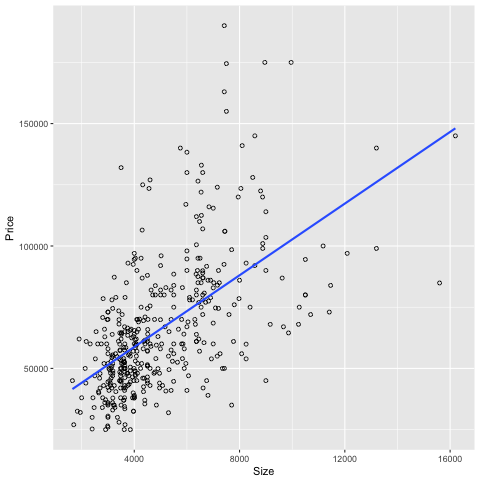

In [4]:
%%R
dataset <- read.csv('./housing-train.csv')
p <- ggplot(dataset, aes(x=dataset[,2], y=dataset[,1])) +
    geom_point(shape=1) + geom_smooth(method=lm, se=FALSE)
print(p + xlab("Size")+ylab("Price"))

# Why use it?

* Questions we may answer:
    * Is there a relationship between house pricing and the number of bedrooms?

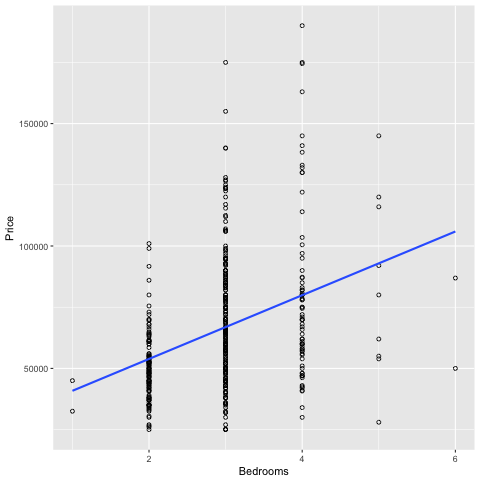

In [5]:
%%R
dataset <- read.csv('./housing-train.csv')
p <- ggplot(dataset, aes(x=dataset[,3], y=dataset[,1])) +
    geom_point(shape=1) + geom_smooth(method=lm, se=FALSE)
print(p + xlab("Bedrooms")+ylab("Price"))

# Regression Problems

* Data set where a **right answer** is given as input to the problem
    * **We know actual prices for houses**
    * Learn what makes the price a certain value from the training data;
    * More right answers based on new training data where we don't know the price already.
* We also call this a regression problem
    * Predict continuous valued output (price)
    * No real discrete delineation 

## <font color='red'>Correlation does not imply causation!</font>

<img src='strange-correlation.png' />

# The math behind it

* Assume that there is a dependency between variables;
    * More specifically, $y$ depends *linearly* on $x_1, x_2, x_3, ..., x_n$
    * In most real world data, <font color='red'>regression is never Linear</font>;
<!--<center><img src="lm2.png" style="padding-top:30px;"/></center> -->


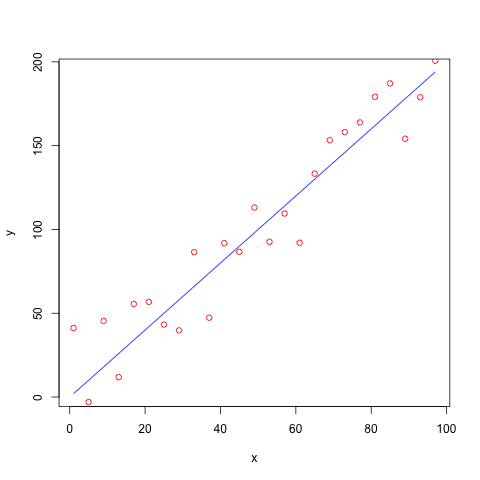

In [6]:
%%R
x <- seq(1, 100, by=4)
y <- x*2
plot(x,y, type="l", col="blue")
z = y+(rnorm(length(y))*20)
points(x,z, col="red")

# The math behind it

* Given samples $(x_i,y_i)$ where $1 \leq i \leq n$
    * Predict $y_{i+1}$ given the new information $x_{i+1}$
* We assume that the dependent variable can be modeled with: $y = \theta_0 + \theta_1x +\epsilon$ where
    * $\theta_0$ is the **intercept**
    * $\theta_1$ is the **slope**
    * $\epsilon$ is the **error**
* Given some estimates $\theta_0$ and $\theta_1$ for the model coeficients, we predict the outcome value $\hat{y}$  using: $\hat{y} = \theta_0+\theta_1x$
* The *ith* residual: $\epsilon_i = y_i - \hat{y}_i$
* A hypothesis takes in some variable;
* Uses parameters determined by a learning system
* Outputs a prediction based on that input

# The math behind it

* If $\theta_1 \geq 0$ then we get a positive slope;
* If $\theta_0 = 1.5$ and $\theta_1 = 0$ then we get straight line parallel with axis X along 1.5;
* The **squared error** is thus: $E=\sum_{i=1}^{m}(y_i - \hat{y}_i)^2$
* We face a **Minimization Problem**

# The math behind it - Normal Equation

* Derivate to get minimum, i.e., $\frac{d}{d\theta_1} = 0$ then solve for $\theta_1$
* Mean Squared Error: $E=\sum_{i=1}^{m}(y_i - \theta_1x_i)^2$
    * Simplify $\theta_0 = 0$<br />
    <center>
$\frac{d}{d\theta_1} = 0$ <br /><br />
</center>
<center>
$-2\sum_{i=1}^{m}x_i(y_i - \theta_1x_i) = 0$<br /><br />
</center>
<center>
$\sum_{i=1}^{m}x_iy_i = \theta_1\sum_{i=1}^{m}x_i^2$<br /><br />
</center>
<center>
$\theta_1 = \frac{\sum_{i=1}^{m}x_iy_i}{\sum_{i=1}^{m}x_i^2}$
</center>

# The math behind it

## Multiple Linear Regression

* We assume that the future data can be modeled with the following: $\hat{y} = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 $ 
* Let's consider now that the $\theta_0, \theta_1, \theta_2, ... \theta_n$ is a vector
* Also, the values of our features $x_1, x_2, x_3, ..., x_n$ are a vector and let's assume that $x_0=1$

$$
\theta=
\begin{bmatrix}
\theta_0\\
\theta_1\\
\theta_2\\
...\\
\theta_n\\
\end{bmatrix}
,\ X=
\begin{bmatrix}
x_0\\
x_1\\
x_2\\
...\\
x_n\\
\end{bmatrix}
$$

# The math behind it

## Multiple Linear Regression (2)

* Thus, in order to estimate $\hat{y}$ in terms of $\theta_0, \theta_1, \theta_2, ..., \theta_n$ and $x_0, x_1, x_2, ..., x_n$ we get:<br /><br />
$$
\hat{y} = \theta_0x_0 + \theta_1x_1+\theta_2x_2+\theta_3x_3+ ...+ \theta_nx_n
$$<br />
then, using a vector product notation we get:<br /><br />
$$
\theta^TX
$$

# The math behind it

## Multiple Linear Regression (3)

* Our **error E** now is a function of the $\theta_0, \theta_1, ... \theta_n$ variables: <br /><br />
$$E(\theta_0,\theta_1,...\theta_n) = \sum_{i=1}^{m} (y_i - \theta_0x_0 + \theta_1x_1+...+ \theta_nx_n)^2$$
<br /><br />
* In order to use the Normal Equation to solve for each $\theta_i$ we have to take the partial derivatives $\frac{\partial}{\partial \theta_i}$

# Error estimation

## Root Mean Square Error
* Differences between values predicted and the values observed;
* Same unit as the observation;<br /><br />
$$\sqrt{\frac{\sum_{i=1}^{m}(\hat{y}_i - y_i)^2}{m}}$$

# Error estimation

## $R^2$
* Amount of variance explained by the model
* Unitless;<br /><br />
$$SS_{res} = \sum_{i=1}^{m}(\hat{y}_i - y_i)$$<br/><br />
$$SS_{tot} = \sum_{i=1}^{m}(y_i - \bar{y})$$<br/><br />

# Error estimation

## $R^2$
$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$